In [1]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from PIL import Image
import os
class CustomDataset(Dataset):
    def __init__(self, root, count=5000, transform=None):
        self.root = root
        self.images = []

        # Load the images from the dataset
        for image_path in os.listdir(root):
            image = Image.open(os.path.join(root, image_path))
            if transform is not None:
                image = transform(image)
            self.images.append(image)
            count-=1
            if(count==0):
              break

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [4]:
import tarfile
path='/content/drive/MyDrive/Gen AI/x ray 14/images_01.tar.gz'
#path='/content/drive/MyDrive/Copy of images_01.tar.gz'
tar = tarfile.open(path, "r:gz")
tar.extractall()
tar.close()

In [ ]:
import os.path
import glob
import cv2
from pathlib import Path

def convertjpg(pngfile,outdir):

    src = cv2.imread(pngfile, cv2.IMREAD_UNCHANGED)

    try:
        #dst = src[100:500, 200:600]
        dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        #print(dst.shape)
        cv2.imwrite(os.path.join(outdir,os.path.basename(pngfile)), dst)
    except Exception as e:
        print(src.shape)
        cv2.imwrite(os.path.join(outdir,os.path.basename(pngfile)), src)

content_path = Path('/').absolute() / 'content'
path=content_path/'grayImages'
if not path.is_dir():
    %mkdir "{path}"
else:
    for file in os.listdir(path):
        os.remove(os.path.join(path,file))
for pngfile in glob.glob(r'/content/images/*.png'):
    convertjpg(pngfile,r"/content/grayImages")

In [ ]:
rm -r '/content/images'

In [6]:
# create a transofrm to apply to each datapoint
#transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels
    transforms.ToTensor(),  # Convert PIL Image to tensor
])

'''# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)'''

#download customdataset--already downloaded
#data_path='/content/drive/MyDrive/Generative models/generated_GAN/Copy of images_01.tar.gz'
data_path='/content/grayImages'
dataset=CustomDataset(data_path,  transform=transform)
#dataset = dataset.transform(transform)

# create train and test dataloaders
batch_size = 100
#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
data_loader= DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
latent_size = 32

In [8]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)

In [9]:
discriminator = nn.Sequential(
    # in: 1 x 64 x 64

    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(data_loader, device)

In [13]:
discriminator = to_device(discriminator, device)


In [14]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

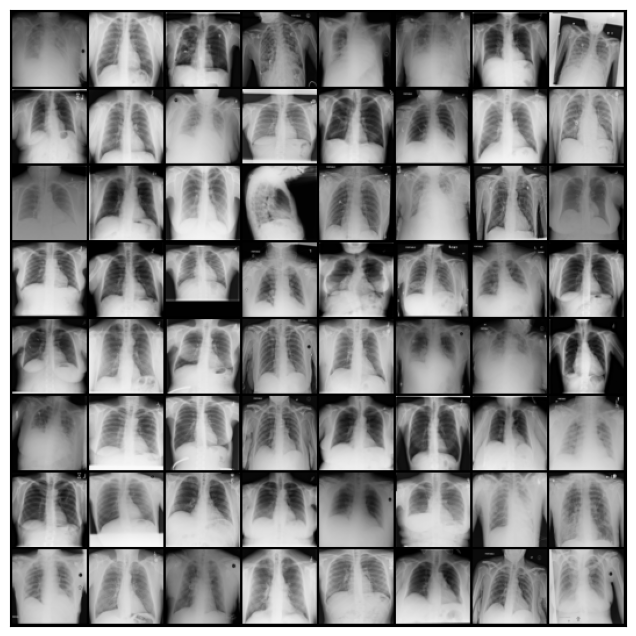

In [15]:
show_batch(data_loader)

torch.Size([100, 1, 64, 64])


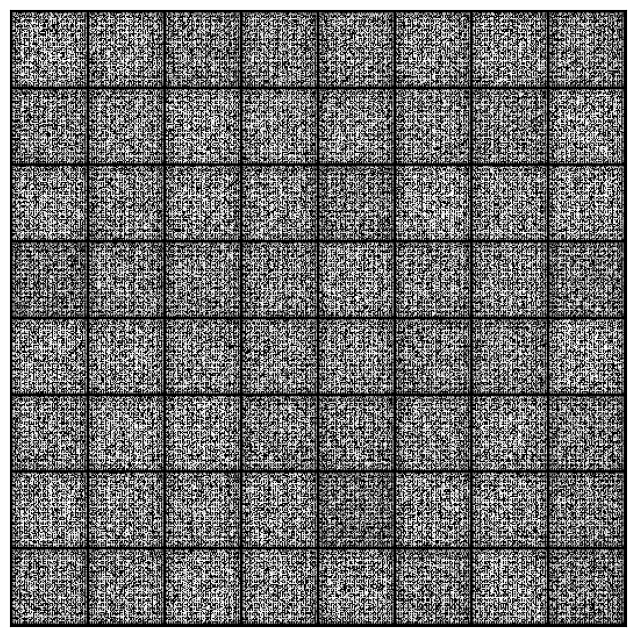

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1).to(device) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [17]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device).to(device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device).to(device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device).to(device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device).to(device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device).to(device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [21]:
sample_dir = '/content/drive/MyDrive/Generative models/generated_GAN'
os.makedirs(sample_dir, exist_ok=True)

In [22]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


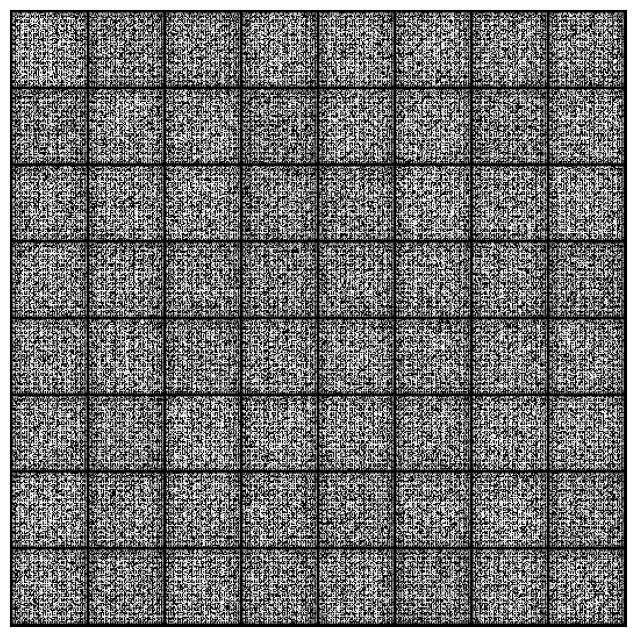

In [23]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device).to(device)
save_samples(0, fixed_latent)

In [24]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images in tqdm(train_dl):
            real_images = real_images.to(device)
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.0002
epochs = 60

In [26]:
history = fit(epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/60], loss_g: 7.2710, loss_d: 0.0049, real_score: 0.9992, fake_score: 0.0041
Saving generated-images-0001.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 7.4600, loss_d: 0.0024, real_score: 0.9997, fake_score: 0.0021
Saving generated-images-0002.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 17.7902, loss_d: 0.1239, real_score: 0.9070, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 7.5891, loss_d: 0.3001, real_score: 0.8058, fake_score: 0.0104
Saving generated-images-0004.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 0.9021, loss_d: 0.9609, real_score: 0.4854, fake_score: 0.1319
Saving generated-images-0005.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 2.2883, loss_d: 0.5593, real_score: 0.7210, fake_score: 0.1687
Saving generated-images-0006.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 3.2180, loss_d: 0.3942, real_score: 0.9069, fake_score: 0.2379
Saving generated-images-0007.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 1.9693, loss_d: 0.8059, real_score: 0.6869, fake_score: 0.3026
Saving generated-images-0008.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 2.4489, loss_d: 0.9090, real_score: 0.5064, fake_score: 0.0405
Saving generated-images-0009.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 2.0063, loss_d: 0.6382, real_score: 0.6795, fake_score: 0.1631
Saving generated-images-0010.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 3.3855, loss_d: 0.8866, real_score: 0.8819, fake_score: 0.4825
Saving generated-images-0011.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 1.8007, loss_d: 0.8554, real_score: 0.5998, fake_score: 0.2423
Saving generated-images-0012.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 1.7686, loss_d: 0.7516, real_score: 0.5777, fake_score: 0.0986
Saving generated-images-0013.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 1.5748, loss_d: 0.8890, real_score: 0.4759, fake_score: 0.0660
Saving generated-images-0014.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 2.3972, loss_d: 0.6111, real_score: 0.6846, fake_score: 0.1645
Saving generated-images-0015.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 4.2209, loss_d: 1.1857, real_score: 0.9021, fake_score: 0.6249
Saving generated-images-0016.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 3.8123, loss_d: 0.3572, real_score: 0.8471, fake_score: 0.1566
Saving generated-images-0017.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 2.3571, loss_d: 1.1130, real_score: 0.3919, fake_score: 0.0436
Saving generated-images-0018.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 2.6700, loss_d: 0.5271, real_score: 0.6668, fake_score: 0.0769
Saving generated-images-0019.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 2.3909, loss_d: 0.6185, real_score: 0.6116, fake_score: 0.0662
Saving generated-images-0020.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 1.8398, loss_d: 0.5933, real_score: 0.6538, fake_score: 0.0928
Saving generated-images-0021.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 4.5225, loss_d: 0.5526, real_score: 0.6145, fake_score: 0.0177
Saving generated-images-0022.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 3.6159, loss_d: 0.4006, real_score: 0.7180, fake_score: 0.0364
Saving generated-images-0023.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 3.4209, loss_d: 0.6772, real_score: 0.6209, fake_score: 0.0724
Saving generated-images-0024.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 3.1740, loss_d: 0.4081, real_score: 0.7287, fake_score: 0.0602
Saving generated-images-0025.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.2679, loss_d: 0.3061, real_score: 0.8959, fake_score: 0.1489
Saving generated-images-0026.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 3.2263, loss_d: 0.4186, real_score: 0.7620, fake_score: 0.1117
Saving generated-images-0027.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 3.7755, loss_d: 0.3621, real_score: 0.7732, fake_score: 0.0797
Saving generated-images-0028.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 4.4674, loss_d: 0.4192, real_score: 0.8782, fake_score: 0.2296
Saving generated-images-0029.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 3.5928, loss_d: 0.6591, real_score: 0.5759, fake_score: 0.0196
Saving generated-images-0030.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 4.7588, loss_d: 0.3900, real_score: 0.7261, fake_score: 0.0348
Saving generated-images-0031.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.2656, loss_d: 0.4605, real_score: 0.6754, fake_score: 0.0358
Saving generated-images-0032.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 3.5871, loss_d: 0.4018, real_score: 0.7813, fake_score: 0.1175
Saving generated-images-0033.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 4.8498, loss_d: 0.2703, real_score: 0.9469, fake_score: 0.1720
Saving generated-images-0034.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 3.0316, loss_d: 0.6517, real_score: 0.6104, fake_score: 0.0870
Saving generated-images-0035.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 4.7126, loss_d: 0.1196, real_score: 0.9176, fake_score: 0.0289
Saving generated-images-0036.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 4.2420, loss_d: 1.0948, real_score: 0.3895, fake_score: 0.0085
Saving generated-images-0037.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 4.3758, loss_d: 0.2049, real_score: 0.9600, fake_score: 0.1424
Saving generated-images-0038.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 3.5945, loss_d: 0.3677, real_score: 0.7445, fake_score: 0.0431
Saving generated-images-0039.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 4.0808, loss_d: 0.3391, real_score: 0.9088, fake_score: 0.1986
Saving generated-images-0040.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 4.1294, loss_d: 0.5589, real_score: 0.6660, fake_score: 0.0606
Saving generated-images-0041.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 4.6080, loss_d: 0.2031, real_score: 0.9168, fake_score: 0.1020
Saving generated-images-0042.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 3.9751, loss_d: 0.1692, real_score: 0.8998, fake_score: 0.0556
Saving generated-images-0043.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 3.0001, loss_d: 0.5018, real_score: 0.6806, fake_score: 0.0481
Saving generated-images-0044.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 4.8188, loss_d: 0.5331, real_score: 0.9810, fake_score: 0.3622
Saving generated-images-0045.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 3.9470, loss_d: 0.2300, real_score: 0.9163, fake_score: 0.1249
Saving generated-images-0046.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 4.0355, loss_d: 0.2405, real_score: 0.9443, fake_score: 0.1562
Saving generated-images-0047.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 3.2654, loss_d: 0.3628, real_score: 0.9436, fake_score: 0.2396
Saving generated-images-0048.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.9871, loss_d: 0.3293, real_score: 0.9740, fake_score: 0.2399
Saving generated-images-0049.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 3.3280, loss_d: 0.2244, real_score: 0.9352, fake_score: 0.1360
Saving generated-images-0050.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 4.6570, loss_d: 0.1928, real_score: 0.9300, fake_score: 0.0949
Saving generated-images-0051.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 2.8661, loss_d: 0.1397, real_score: 0.9178, fake_score: 0.0497
Saving generated-images-0052.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 2.5464, loss_d: 0.1715, real_score: 0.8799, fake_score: 0.0349
Saving generated-images-0053.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 5.2830, loss_d: 0.4189, real_score: 0.9632, fake_score: 0.2960
Saving generated-images-0054.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 3.5720, loss_d: 1.0672, real_score: 0.9822, fake_score: 0.5984
Saving generated-images-0055.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 5.2962, loss_d: 0.1587, real_score: 0.8860, fake_score: 0.0278
Saving generated-images-0056.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 2.8422, loss_d: 0.0946, real_score: 0.9593, fake_score: 0.0494
Saving generated-images-0057.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.5377, loss_d: 0.1667, real_score: 0.9548, fake_score: 0.1031
Saving generated-images-0058.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 3.9989, loss_d: 0.1439, real_score: 0.9439, fake_score: 0.0791
Saving generated-images-0059.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 4.1886, loss_d: 0.1773, real_score: 0.9098, fake_score: 0.0707
Saving generated-images-0060.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

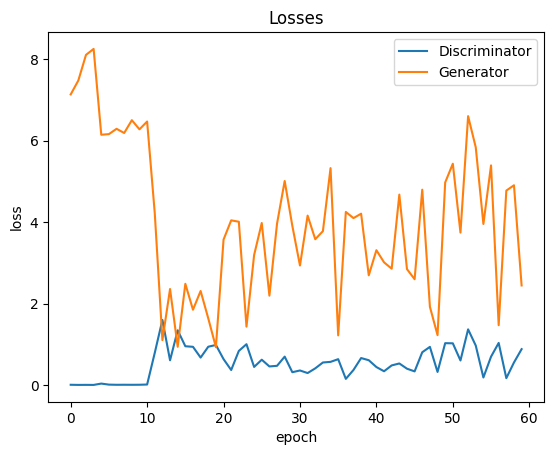

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

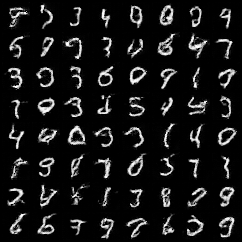

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Generative models/generated_GAN/generated-images-0060.png')

In [27]:
#generate 4999 images
sample_dir = '/content/drive/MyDrive/Generative models/chest_xray_artificial_dataset'
os.makedirs(sample_dir, exist_ok=True)

for i in range(5000):
  fixed_latent = torch.randn(1, latent_size, 1, 1, device=device).to(device)
  save_samples(i, fixed_latent, False)

Saving generated-images-0000.png
Saving generated-images-0001.png
Saving generated-images-0002.png
Saving generated-images-0003.png
Saving generated-images-0004.png
Saving generated-images-0005.png
Saving generated-images-0006.png
Saving generated-images-0007.png
Saving generated-images-0008.png
Saving generated-images-0009.png
Saving generated-images-0010.png
Saving generated-images-0011.png
Saving generated-images-0012.png
Saving generated-images-0013.png
Saving generated-images-0014.png
Saving generated-images-0015.png
Saving generated-images-0016.png
Saving generated-images-0017.png
Saving generated-images-0018.png
Saving generated-images-0019.png
Saving generated-images-0020.png
Saving generated-images-0021.png
Saving generated-images-0022.png
Saving generated-images-0023.png
Saving generated-images-0024.png
Saving generated-images-0025.png
Saving generated-images-0026.png
Saving generated-images-0027.png
Saving generated-images-0028.png
Saving generated-images-0029.png
Saving gen

In [28]:
!pip install pytorch-fid

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [31]:
!python -m pytorch_fid /content/grayImages /content/drive/MyDrive/Generative\ models/chest_xray_artificial_dataset --device cuda:0

  0% 0/100 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100% 100/100 [02:51<00:00,  1.71s/it]
100% 100/100 [01:28<00:00,  1.13it/s]
FID:  288.4673474763308
